In [1]:
import pandas as pd
import numpy as np
import datetime
import time

from tda import auth, client
import json
from config import api_key, redirect_uri, token_path, account_id, executable_path

# Machine learning libraries
from sklearn.svm import SVC
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, classification_report
import talib as ta
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

from utils import *
%load_ext autoreload
%autoreload 2

In [2]:
# set connection with brocker account
connection = get_account_acess(api_key, redirect_uri, token_path, account_id, executable_path)

In [35]:
# get historical data
data = pd.DataFrame(connection.get_price_history_every_minute('TSLA', 
                                                              start_datetime = datetime.datetime.fromisoformat('2022-04-19 12:36:00'),
                                                              need_extended_hours_data=False).json()['candles'])
data['datetime'] = data['datetime'].apply(lambda x : datetime.datetime.fromtimestamp(x/1000.0))
data['datetime'] = data['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d %H:%M:%S'))
data = data[data.datetime>='2022-04-19 12:36:00']
data.datetime = data.datetime.apply(lambda x: str(x))
data.datetime = data.datetime.apply(lambda x: x[:-3])
data = data.set_index('datetime')
data.head()

,open,high,low,close,volume
datetime,,,,,
2022-04-19 12:36,1025.49,1025.50,1024.7720,1024.7720,4119
2022-04-19 12:37,1024.75,1024.75,1023.5400,1024.1900,19469
2022-04-19 12:38,1024.19,1024.22,1023.4000,1024.2200,10723
2022-04-19 12:39,1024.33,1024.60,1024.0978,1024.1500,2956
2022-04-19 12:40,1024.32,1024.48,1023.2300,1023.7201,12342


In [36]:
# Create a column 'Ret' with the calculation of returns
data['Ret'] = (data['open'].shift(-1)-data['open'])/data['open']
# Create a column by name, 'Signal' and initialize with 0
data['Signal'] = 0
# Assign a value of 1 to 'Signal' column for the quantile with the highest returns
data.loc[data['Ret'] > data['Ret'].quantile(q=0.66), 'Signal'] = 1
# Assign a value of -1 to 'Signal' column for the quantile with the lowest returns
data.loc[data['Ret'] < data['Ret'].quantile(q=0.34), 'Signal'] = -1

In [37]:
data.head()

,open,high,low,close,volume,Ret,Signal
datetime,,,,,,,
2022-04-19 12:36,1025.49,1025.50,1024.7720,1024.7720,4119,-0.000722,-1
2022-04-19 12:37,1024.75,1024.75,1023.5400,1024.1900,19469,-0.000546,-1
2022-04-19 12:38,1024.19,1024.22,1023.4000,1024.2200,10723,0.000137,0
2022-04-19 12:39,1024.33,1024.60,1024.0978,1024.1500,2956,-0.000010,0
2022-04-19 12:40,1024.32,1024.48,1023.2300,1023.7201,12342,-0.000430,-1


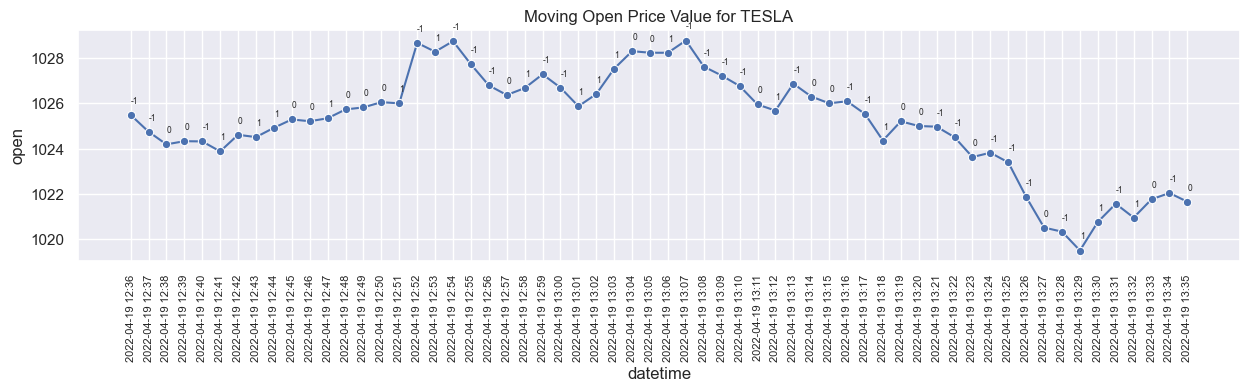

In [38]:
fig, ax = plt.subplots(figsize=(15,3))
plot = sns.lineplot(x='datetime', y='open', data=data.reset_index().iloc[:60], marker='o')
# Annotate label points 
for x,y,m in data.reset_index().iloc[:60][['datetime','open','Signal']].values:
        ax.text(x,y+0.5,m, size=6)
plt.title("Moving Open Price Value for TESLA")
plt.setp(plot.get_xticklabels(), rotation=90, size=8)
plt.show()

In [39]:
df_predictions = pd.read_csv('testing_bot_results_4_19.csv', index_col='datetime')[['quote','Pred_Signal']]
df_predictions.head()

,quote,Pred_Signal
datetime,,
2022-04-19 12:36,1025.5500,1
2022-04-19 12:37,1024.8199,0
2022-04-19 12:38,1024.2100,-1
2022-04-19 12:39,1024.6600,0
2022-04-19 12:40,1024.3199,0


In [41]:
df_pred = pd.merge(data,df_predictions, how='left', left_index=True, right_index=True)

In [44]:
cm = confusion_matrix(df_pred.Signal, df_pred.Pred_Signal)
cm

array([[18, 45,  6],
       [13, 48,  5],
       [13, 49,  7]], dtype=int64)

In [46]:
make_confusion_matrix(cf=cm, 
                      categories=['-1', '0', '1'], figsize=(4,3), percent=False,
                      title="Actual and Predicted values")
plt.show()

NameError: name 'make_confusion_matrix' is not defined